CASA 0002 - Urban Simulation
Final Asssessment - London Underground Resilience
Gavin Rolls
9 February 2024

Environment Setup

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy
import networkx as nx
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

# Part I - Topological Network Resilience

In [4]:
#Data Load in & Cleaning
#Borrowed from Week 10 Data Processing

#tlf provides passenger flow data for each network separately
#we need to create a list of all the different files we need
files = ['NBT19MTT2b_od__DLR_tb_wf.csv', 
         'NBT19MTT2b_od__EZL_tb_wf.csv', 
         'NBT19MTT2b_od__LO_tb_wf.csv', 
         'NBT19MTT2b_od__LU_tb_wf.csv']

#create an empty list to store dataframes for each file
dfs = []

#iterate through our files list, read the file and append to our dataframe list
for file in files:
    dfs.append(pd.read_csv('Data/' + file))
    
#merge all dataframes
london_OD = pd.concat(dfs, ignore_index=True)

In [5]:
### Get the mnlc codes 
definition_df = pd.read_excel('data/NBT19_Definitions.xlsx', 'Stations')

#we will drop any missing values from our dataframe
definition_df.dropna(inplace=True)

#transform mnlc codes from floats to int
definition_df.MNLC = definition_df.MNLC.astype(int)

#add the station names
london_OD['station_origin'] = london_OD['mode_mnlc_o'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])
london_OD['station_destination'] = london_OD['mode_mnlc_d'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])

# we will only keep passenger flows for the timeband we are interested in
london_OD_AMpeak = london_OD[['station_origin', 'station_destination', '3']].copy()

#rename column
london_OD_AMpeak.rename({'3':'flows'}, axis=1, inplace=True)

#since the flows are averages the are stored as flows.
#for our analysis we will turn the into ints
london_OD_AMpeak.flows = london_OD_AMpeak.flows.astype(int)

station_origin = list(london_OD_AMpeak.station_origin.values)
station_destination = list(london_OD_AMpeak.station_destination.values)
all_stations = list(set(station_origin + station_destination))
all_stations = sorted(all_stations, key=str.lower)

all_stations

['Abbey Road',
 'Acton Central',
 'Acton Main Line',
 'Acton Town',
 'Aldgate',
 'Aldgate East',
 'All Saints',
 'Alperton',
 'Amersham',
 'Anerley',
 'Angel',
 'Archway',
 'Arnos Grove',
 'Arsenal',
 'Baker Street',
 'Balham LU',
 'Bank and Monument',
 'Barbican',
 'Barking',
 'Barkingside',
 'Barons Court',
 'Battersea Park',
 'Bayswater',
 'Beckton',
 'Beckton Park',
 'Becontree',
 'Belsize Park',
 'Bermondsey',
 'Bethnal Green LO',
 'Bethnal Green LU',
 'Blackfriars LU',
 'Blackhorse Road',
 'Blackwall',
 'Bond Street',
 'Borough',
 'Boston Manor',
 'Bounds Green',
 'Bow Church',
 'Bow Road',
 'Brent Cross',
 'Brentwood',
 'Brixton LU',
 'Brockley',
 'Bromley-by-Bow',
 'Brondesbury',
 'Brondesbury Park',
 'Bruce Grove',
 'Buckhurst Hill',
 'Burnt Oak',
 'Bush Hill Park',
 'Bushey',
 'Caledonian Road',
 'Caledonian Road & Barnsbury',
 'Cambridge Heath',
 'Camden Road',
 'Camden Town',
 'Canada Water',
 'Canary Wharf DLR',
 'Canary Wharf LU',
 'Canning Town',
 'Cannon Street LU',
 'C

In [ ]:
#Clean with Regex
london_OD_AMpeak['station_origin']= london_OD_AMpeak.station_origin.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )
london_OD_AMpeak['station_destination']=london_OD_AMpeak.station_destination.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )

#group by origin and destination station and sum the flows
london_OD_AMpeak = london_OD_AMpeak.groupby(['station_origin', 'station_destination'], as_index=False).sum()

london_OD_AMpeak.head()

In [ ]:
### Load London Underground shapefile data

#read in the data using geopandas
stations = gpd.read_file('data/tfl_stations.json')
lines = gpd.read_file('data/tfl_lines.json')

#project data to British National Grid
#we do this so we can work in meters
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)


### Clean station names

#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])

In [ ]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

#set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))

#check plot to make sure there are no errors
stations.plot(markersize=2)



In [ ]:
### Get all line names

#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names

# check the data for each line
for line in line_names:
    #I'm removing thameslink 6tph line because there are not corresponding stations in station file
    if line == 'Thameslink 6tph line':
        continue
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    temp_lines = lines[lines.lines.str.contains(line)]
    base = temp_lines.plot(ax=ax)
    temp_stations = stations[stations.lines.str.contains(line)]
    temp_stations.plot(ax=base, markersize=20)
    plt.show()

#We can see that east london line is incomplete
#digging into this however we notice that it's because east london is actually part of the overground
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')

#Our TFL data doesn't include tramlink, emirates air lines, and crossrail is still in construction (except not really)
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']

#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G

In [ ]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })

#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs
edge_gdf.plot()
edge_gdf.head()

### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

#plot to sanity check
edge_gdf.plot()

#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

#this is our resulting dataframe
edge_gdf.head()

#let's replace the ids with the actual name
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

edge_gdf.head()

In [ ]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

#let's plot
#notice that even though we created the real geometries, the graph still plots just straight line
#this is because networkx doesn't have a concept of a edge geometry
#however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

#save position to graph
nx.set_node_attributes(G, pos, 'coords')


In [ ]:
### Merge Network with OD data

#check that our OD data and network data match
OD_names = set(london_OD_AMpeak.station_origin.unique())
network_names = set([n for n in G.nodes()])

network_names.symmetric_difference(OD_names)

name_map = {
    'Heathrow Terminal 4 EL': 'Heathrow Terminal 4',
    'Heathrow Terminals 123': 'Heathrow Terminals 2 & 3',
    'Heathrow Terminals 2 & 3 EL': 'Heathrow Terminals 2 & 3',
    "Walthamstow Queen's Road": 'Walthamstow Queens Road'
}

london_OD_AMpeak.station_origin = london_OD_AMpeak.station_origin.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)
london_OD_AMpeak.station_destination = london_OD_AMpeak.station_destination.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)

#let's filter out the stations that we don't have in our network
OD_names = set(london_OD_AMpeak.station_origin.unique())
_filter = list(network_names.symmetric_difference(OD_names))
_filter

london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_origin.isin(_filter)]
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_destination.isin(_filter)]


## Adding Flow Data - May have to move this bit around or restructure it once lines have been separated to account for transfers

In [3]:
#Add flow data to our network

#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

#calculate shortest paths for all flows and add data to dict
for i, row in london_OD_AMpeak.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.flows
        except:
            flows[(v,u)] += row.flows

#set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows')

#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

#save graph
for i in G.nodes():
    G.nodes[i]['coords'] = str(G.nodes[i]['coords'])
nx.write_graphml_lxml(G, "outputs/london_updated.graph")

**Create OD pairs with distance, population and jobs**

Lastly for our spatial interaction we need to add distance data to our OD list, as well as population and jobs.
Since we don't have population and jobs data at a station level, we will use total in and out flows as proxies.

#### Create Origin Destination matrix
OD = pd.pivot_table(london_OD_AMpeak, 
                    values ="flows", 
                    index="station_origin", 
                    columns = "station_destination",
                    aggfunc=sum, 
                    margins=True)
OD.fillna(0, inplace=True)
OD = OD.astype(int)
OD.to_csv('outputs/OD_matrix.csv')

OD.sort_values(by='All').tail(10)

#lets get total at origin and total at destinations
origin = OD.loc[:,'All'].to_dict()
destination = OD.loc['All',:].to_dict()

#lets add this data as population and jobs
london_OD_AMpeak['population'] = london_OD_AMpeak.station_origin.apply(lambda x: origin[x])
london_OD_AMpeak['jobs'] = london_OD_AMpeak.station_destination.apply(lambda x: destination[x])

#get distance between stations within the network
london_OD_AMpeak['distance'] = -1
for i, row in london_OD_AMpeak.iterrows():
    source = row.station_origin
    target = row.station_destination
    distance = nx.shortest_path_length(G, source, target, weight='length', method='dijkstra')
    london_OD_AMpeak.loc[i, 'distance'] = distance

# or you could use all_pairs_dijkstra_path_length(G, weight='length') to get all distances at once...
london_OD_AMpeak.to_csv('outputs/london_flows.csv', index=False)

There was some confusion about missing potential flows in the network for the assignment. This is how you would do the complete square matrix.

# remove the ALL column and row
OD_melt = OD.iloc[:-1,:-1]
# melt OD back to a long dataframe
OD_melt = OD_melt.reset_index().melt(id_vars='station_origin', value_vars=OD.columns[:-1])
OD_melt.columns = ['station_origin', 'station_destination', 'flows']
# remove the self flows
OD_melt = OD_melt[OD_melt.station_origin != OD_melt.station_destination]
OD_melt.head()


OD_melt['population'] = OD_melt.station_origin.apply(lambda x: origin[x])
OD_melt['jobs'] = OD_melt.station_destination.apply(lambda x: destination[x])

# get distance between stations within the network
OD_melt['distance'] = -1
for i, row in OD_melt.iterrows():
    source = row.station_origin
    target = row.station_destination
    distance = nx.shortest_path_length(G, source, target, weight='length', method='dijkstra')
    OD_melt.loc[i, 'distance'] = distance

print(OD_melt.shape)
OD_melt.head()

OD_melt.sort_values('flows', ascending=False).head(20)


# Part II - Spatial Interaction Models

Data Loading & Preprocessing

In [3]:
#Reading in flows
flows = pd.read_csv("./Data/london_flows.csv")

#Check data loaded
flows.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [5]:
#Metric Calculations(Taken from Prac3)
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(np.sqrt(res.mean()), 3)
    
    return RMSE

Set up Origin Constrained Model with Exponential Decay.

I will use population as our origin mass factor and employment count as our destination mass factor to simulate maximum commute flow during the morning rush.

In [4]:
#Calculate log of destination employment count with small addition to solve div by zero error
flows['log_dest_jobs'] = np.log(flows['jobs'] + .001)

#Formula for origin constrained equation (with exponential decay)
eq_form = 'flows ~ station_origin + log_dest_jobs + distance-1'

#Doubly Constrained Model with smf
sim = smf.glm(formula = eq_form, data = flows, family=sm.families.Poisson()).fit()

print(sim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61451
Model:                            GLM   Df Residuals:                    61051
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.2195e+05
Date:                Fri, 08 Mar 2024   Deviance:                   1.6717e+06
Time:                        11:40:28   Pearson chi2:                 2.42e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [7]:
#Generate Predictions and add to flows dataframe
flows["flows_default"] = np.round(sim.mu)

#Summary Statistics
print("RSquared =")
print(CalcRSqaured(flows["flows"], flows["flows_default"]))
print("RMSE =")
print(CalcRMSE(flows["flows"], flows["flows_default"]))

RSquared =
0.44826852677653783
RMSE =
97.864


Our log_jobs parameter is 0.7509 and our distance parameter is -0.00015 (Remember beta is the inverse of this)

In [8]:
#Matrix View (Code Taken from Practical 3)
matrix = flows.pivot_table(values ="flows_default", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
matrix

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_84129/700295113.py:2: FutureWarning: The provided callable <function sum at 0x107465620> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_default", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_84129/700295113.py:2: FutureWarning: The provided callable <function sum at 0x107465620> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_default", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_84129/700295113.py:2: FutureWarning: The provided callable <function sum at 0

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,598.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3745.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2884.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4861.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,31.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3099.0


## Scenario A - Decrease in Jobs at Canary Wharf

In [9]:
#Create new jobs column for scenario a and cut Canary Wharf's jobs in half
flows["jobs_scenario_a"] = flows["jobs"]

#Find Canary Wharf Rows
cw_indices = flows.index[flows['station_destination'] == 'Canary Wharf']

#Divide by Two
flows.loc[cw_indices, 'jobs_scenario_a'] /= 2

#Check it's worked
flows.head()

,station_origin,station_destination,flows,population,jobs,distance,log_dest_jobs,flows_default,jobs_scenario_a
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,78.0,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091312,2.0,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499789,4.0,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,99.0,29386
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,56.0,15428


In [10]:
#Set parameters 
params = sim.params
alpha_i = params[:2]
gamma = params[-2]
beta = -params[-1]

coefs = pd.DataFrame(sim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)

#Strip coef column content
coefs["coef"] = coefs["coef"].str.lstrip('station_origin[').str.rstrip(']')

flows = flows.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
flows.drop(columns = ["coef"], inplace = True)

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_84129/3348131867.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = params[-2]
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_84129/3348131867.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = -params[-1]


In [11]:
#Calculate flows using 'raw' equation

#Recalculate A_i such that flows between other stations are recalibrated correctly
Dj_gamma = flows["jobs_scenario_a"]**gamma
dist_decay = np.exp(flows['distance']*(-beta))

#Recalculate alpha_i for scenario a
flows["alpha_i_partial"] = Dj_gamma * dist_decay

#Sum over all destinations
A_i = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial"].agg(np.sum))

#Divide over 1
A_i["alpha_i_partial"] = 1/A_i["alpha_i_partial"]

#Rename
A_i.rename(columns={"alpha_i_partial":"alpha_i_sec_a"}, inplace=True)

#and write the A_i values back into the dataframe
flows = flows.merge(A_i, left_on="station_origin", right_index=True, how="left")

#Calculate new flows with change @ Canary Wharf
flows["flows_scenario_a"] = np.round(flows["alpha_i_sec_a"]*flows["population"]*Dj_gamma*dist_decay)

flows.head(50)

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_84129/133780993.py:11: FutureWarning: The provided callable <function sum at 0x107465620> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial"].agg(np.sum))


,station_origin,station_destination,flows,population,jobs,distance,log_dest_jobs,flows_default,jobs_scenario_a,alpha_i,alpha_i_partial,alpha_i_sec_a,flows_scenario_a
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,78.0,78549,-2.881022,1390.576011,0.000100,84.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091312,2.0,442,-2.881022,26.857420,0.000100,2.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499789,4.0,665,-2.881022,74.540461,0.000100,4.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,99.0,29386,-2.881022,1051.967464,0.000100,63.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,56.0,15428,-2.881022,997.802881,0.000100,60.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,7.096722,4.0,1208,-2.881022,75.230123,0.000100,5.0
6,Abbey Road,Custom House,0,599,845,3824.855630,6.739338,5.0,845,-2.881022,88.567990,0.000100,5.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,7.466228,4.0,1748,-2.881022,75.483796,0.000100,5.0
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.745238,3.0,850,-2.881022,59.139626,0.000100,4.0
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.415099,4.0,611,-2.881022,68.044833,0.000100,4.0


In [12]:
#Matrix View (Code Taken from Practical 3)
matrix = flows.pivot_table(values ="flows_scenario_a", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
matrix

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_84129/407003000.py:2: FutureWarning: The provided callable <function sum at 0x107465620> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_scenario_a", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_84129/407003000.py:2: FutureWarning: The provided callable <function sum at 0x107465620> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_scenario_a", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_84129/407003000.py:2: FutureWarning: The provided callable <function su

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,602.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,14.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3746.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,28.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2880.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,42.0,53.0,NaN,NaN,NaN,NaN,31.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4858.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534.0
Woodside Park,NaN,NaN,2.0,20.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3098.0


To verify that commuters are indeed preserved, we can take the sum total traveler count from our matrix view here, 
1,541,507, and compare it to the total count from our previous matrix, which is 1,541,509. The difference of two commuters can be comfortably attributed to rounding errors


## Scenario B - Increase in Travel Cost

In [13]:
#Establish new value for beta - reflecting cost of travel (in terms of distance)
print("Default Beta: " + str(beta))

#Given that beta is relatively small, I will consider a scenario in which beta is 50% larger and 100% larger from its default value
beta_b1 = beta*1.5
beta_b2 = beta*2

#Calculate flows using 'raw' equation

#Recalculate A_i such that flows between other stations are recalibrated correctly
Dj_gamma = flows["jobs"]**gamma
dist_decay_b1 = np.exp(flows['distance']*(-beta_b1))
dist_decay_b2 = np.exp(flows['distance']*(-beta_b2))

#Recalculate alpha_i for scenario a
flows["alpha_i_partial_b1"] = Dj_gamma * dist_decay_b1
flows["alpha_i_partial_b2"] = Dj_gamma * dist_decay_b2

#Sum over all destinations
A_i_b1 = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial_b1"].agg(np.sum))
A_i_b2 = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial_b2"].agg(np.sum))

#Divide over 1
A_i_b1["alpha_i_partial_b1"] = 1/A_i_b1["alpha_i_partial_b1"]
A_i_b2["alpha_i_partial_b2"] = 1/A_i_b2["alpha_i_partial_b2"]

#Rename
A_i_b1.rename(columns={"alpha_i_partial_b1":"alpha_i_sec_b1"}, inplace=True)
A_i_b2.rename(columns={"alpha_i_partial_b2":"alpha_i_sec_b2"}, inplace=True)

#and write the A_i values back into the dataframe
flows = flows.merge(A_i_b1, left_on="station_origin", right_index=True, how="left")
flows = flows.merge(A_i_b2, left_on="station_origin", right_index=True, how="left")

#Calculate new flows for scenario b1
flows["flows_scenario_b1"] = np.round(flows["alpha_i_sec_b1"]*flows["population"]*Dj_gamma*dist_decay_b1)

#Calculate new flows for scenario b2
flows["flows_scenario_b2"] = np.round(flows["alpha_i_sec_b2"]*flows["population"]*Dj_gamma*dist_decay_b2)

flows.head(50)

Default Beta: 0.00015081738474390007


/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_84129/1809123172.py:20: FutureWarning: The provided callable <function sum at 0x107465620> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i_b1 = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial_b1"].agg(np.sum))
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_84129/1809123172.py:21: FutureWarning: The provided callable <function sum at 0x107465620> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i_b2 = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial_b2"].agg(np.sum))


,station_origin,station_destination,flows,population,jobs,distance,log_dest_jobs,flows_default,jobs_scenario_a,alpha_i,alpha_i_partial,alpha_i_sec_a,flows_scenario_a,alpha_i_partial_b1,alpha_i_partial_b2,alpha_i_sec_b1,alpha_i_sec_b2,flows_scenario_b1,flows_scenario_b2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,78.0,78549,-2.881022,1390.576011,0.000100,84.0,753.166005,407.930978,0.000123,0.000155,55.0,38.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091312,2.0,442,-2.881022,26.857420,0.000100,2.0,14.137134,7.441466,0.000123,0.000155,1.0,1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499789,4.0,665,-2.881022,74.540461,0.000100,4.0,56.072215,42.179687,0.000123,0.000155,4.0,4.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,99.0,29386,-2.881022,1051.967464,0.000100,63.0,1206.332683,822.026645,0.000123,0.000155,89.0,76.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,56.0,15428,-2.881022,997.802881,0.000100,60.0,843.428862,712.938656,0.000123,0.000155,62.0,66.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,7.096722,4.0,1208,-2.881022,75.230123,0.000100,5.0,45.437299,27.443105,0.000123,0.000155,3.0,3.0
6,Abbey Road,Custom House,0,599,845,3824.855630,6.739338,5.0,845,-2.881022,88.567990,0.000100,5.0,66.376504,49.745290,0.000123,0.000155,5.0,5.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,7.466228,4.0,1748,-2.881022,75.483796,0.000100,5.0,39.751601,20.934159,0.000123,0.000155,3.0,2.0
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.745238,3.0,850,-2.881022,59.139626,0.000100,4.0,36.137247,22.081651,0.000123,0.000155,3.0,2.0
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.415099,4.0,611,-2.881022,68.044833,0.000100,4.0,50.484924,37.456591,0.000123,0.000155,4.0,3.0


In [14]:
#Matrix View (Code Taken from Practical 3)
matrix = flows.pivot_table(values ="flows_scenario_b1", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
matrix

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_84129/1370140591.py:2: FutureWarning: The provided callable <function sum at 0x107465620> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_scenario_b1", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_84129/1370140591.py:2: FutureWarning: The provided callable <function sum at 0x107465620> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_scenario_b1", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_84129/1370140591.py:2: FutureWarning: The provided callable <functi

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,597.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,8.0,8.0,NaN,20.0,0.0,NaN,11.0,...,9.0,2.0,1.0,26.0,NaN,0.0,NaN,0.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,46.0,NaN,NaN,0.0,NaN,29.0,...,1.0,NaN,1.0,1.0,NaN,0.0,NaN,0.0,NaN,2875.0
Aldgate East,NaN,NaN,1.0,50.0,NaN,NaN,0.0,0.0,NaN,31.0,...,1.0,0.0,1.0,1.0,NaN,0.0,NaN,0.0,NaN,3156.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,36.0,51.0,NaN,NaN,NaN,NaN,23.0,...,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4861.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529.0
Woodside Park,NaN,NaN,1.0,16.0,15.0,NaN,0.0,NaN,NaN,32.0,...,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


In [15]:
#All Scenarios Compared Directly against each other
col_names = ['station_origin', 'station_destination', 'flows_default', 'flows_scenario_a', 'flows_scenario_b1', 'flows_scenario_b2']

flows.iloc[:][col_names].head(50)


,station_origin,station_destination,flows_default,flows_scenario_a,flows_scenario_b1,flows_scenario_b2
0,Abbey Road,Bank and Monument,78.0,84.0,55.0,38.0
1,Abbey Road,Beckton,2.0,2.0,1.0,1.0
2,Abbey Road,Blackwall,4.0,4.0,4.0,4.0
3,Abbey Road,Canary Wharf,99.0,63.0,89.0,76.0
4,Abbey Road,Canning Town,56.0,60.0,62.0,66.0
5,Abbey Road,Crossharbour,4.0,5.0,3.0,3.0
6,Abbey Road,Custom House,5.0,5.0,5.0,5.0
7,Abbey Road,Cutty Sark,4.0,5.0,3.0,2.0
8,Abbey Road,Cyprus,3.0,4.0,3.0,2.0
9,Abbey Road,Devons Road,4.0,4.0,4.0,3.0


## Analysis of Changes in Commuter Flow

Ideas

Scatterplot of average commuters by distance between station by scenario - could run regression here?
Percent difference in commute flows per station pair between the models (could also be scatterplot)


In [16]:
#Making new dataframe to mess with for analysis
condensed = flows.iloc[:][col_names]

#Canary Wharf Changes
condensed['change_a'] = condensed['flows_scenario_a'] - condensed['flows_default']

print('Median Change to Scenario A: ' + str(np.median(condensed['change_a'])))
print('Percent of pairs with increased flow: ' + str((condensed['change_a'] > 0).mean() * 100))
print('Percent of pairs with no change in flow: ' + str((condensed['change_a'] == 0).mean() * 100))
print('Percent of pairs with decreased flow: ' + str((condensed['change_a'] < 0).mean() * 100))

canary_wharf_rows = condensed[condensed['station_destination'] == 'Canary Wharf']

canary_orig = canary_wharf_rows['flows_default'].sum()
canary_new = canary_wharf_rows['flows_scenario_a'].sum()

print('Original Flows to Canary Wharf: ' + str(canary_orig))
print('New Flows to Canary Wharf: ' + str(canary_new))
print('Percent decrease of flows to Canary Wharf: ' + str(((canary_new - canary_orig) / canary_orig) * 100))

condensed['pct_change_a'] = abs(((condensed['flows_scenario_a'] - condensed['flows_default']) / condensed['flows_default']) * 100)

pct_change_a = condensed['pct_change_a']
valid_values_a = pct_change_a[np.isfinite(pct_change_a)]
average_a = np.mean(valid_values_a)
print('Average Percent Change in Scenario A: {:.2f}'.format(average_a))

Median Change to Scenario A: 0.0
Percent of pairs with increased flow: 14.44402857561309
Percent of pairs with no change in flow: 85.05964101479228
Percent of pairs with decreased flow: 0.49633040959463637
Original Flows to Canary Wharf: 48514.0
New Flows to Canary Wharf: 30075.0
Percent decrease of flows to Canary Wharf: -38.00758543925465
Average Percent Change in Scenario A: 1.33


In [17]:
#Scenario B Changes

#General stats
condensed['change_b1'] = condensed['flows_scenario_b1'] - condensed['flows_default']
condensed['change_b2'] = condensed['flows_scenario_b2'] - condensed['flows_default']

print('Median Change to Scenario B1: ' + str(np.median(condensed['change_b1'])))
print('Percent of pairs with increased flow: ' + str((condensed['change_b1'] > 0).mean() * 100))
print('Percent of pairs with no change in flow: ' + str((condensed['change_b1'] == 0).mean() * 100))
print('Percent of pairs with decreased flow: ' + str((condensed['change_b1'] < 0).mean() * 100))

print('Median Change to Scenario B2: ' + str(np.median(condensed['change_b2'])))
print('Percent of pairs with increased flow: ' + str((condensed['change_b2'] > 0).mean() * 100))
print('Percent of pairs with no change in flow: ' + str((condensed['change_b2'] == 0).mean() * 100))
print('Percent of pairs with decreased flow: ' + str((condensed['change_b2'] < 0).mean() * 100))


condensed['pct_change_b1'] = abs(((condensed['flows_scenario_b1'] - condensed['flows_default']) / condensed['flows_default']) * 100)
condensed['pct_change_b2'] = abs(((condensed['flows_scenario_b2'] - condensed['flows_default']) / condensed['flows_default']) * 100)

pct_change_b1 = condensed['pct_change_b1']
valid_values_b1 = pct_change_b1[np.isfinite(pct_change_b1)]
average_b1 = np.mean(valid_values_b1)
print('Average Percent Change in Scenario B1: {:.2f}'.format(average_b1))

pct_change_b2 = condensed['pct_change_b2']
valid_values_b2 = pct_change_b2[np.isfinite(pct_change_b2)]
average_b2 = np.mean(valid_values_b2)
print('Average Percent Change in Scenario B2: {:.2f}'.format(average_b2))

print("\nDistances Travelled:")

print("\nScenario A:")
print(sum(flows['distance']*flows['flows_scenario_a']) / sum(flows['flows_scenario_a']))
print("\nScenario B1:")
print(sum(flows['distance']*flows['flows_scenario_b1']) / sum(flows['flows_scenario_b1']))
print("\nScenario B2:")
print(sum(flows['distance']*flows['flows_scenario_b2']) / sum(flows['flows_scenario_b2']))


Median Change to Scenario B1: -1.0
Percent of pairs with increased flow: 15.243039169419536
Percent of pairs with no change in flow: 23.438186522595238
Percent of pairs with decreased flow: 61.31877430798522
Median Change to Scenario B2: -2.0
Percent of pairs with increased flow: 13.635254104896585
Percent of pairs with no change in flow: 17.579860376560184
Percent of pairs with decreased flow: 68.78488551854322
Average Percent Change in Scenario B1: 38.61
Average Percent Change in Scenario B2: 63.15

Distances Travelled:

Scenario A:
8592.231928550276

Scenario B1:
7236.4897226661205

Scenario B2:
6042.91408596027


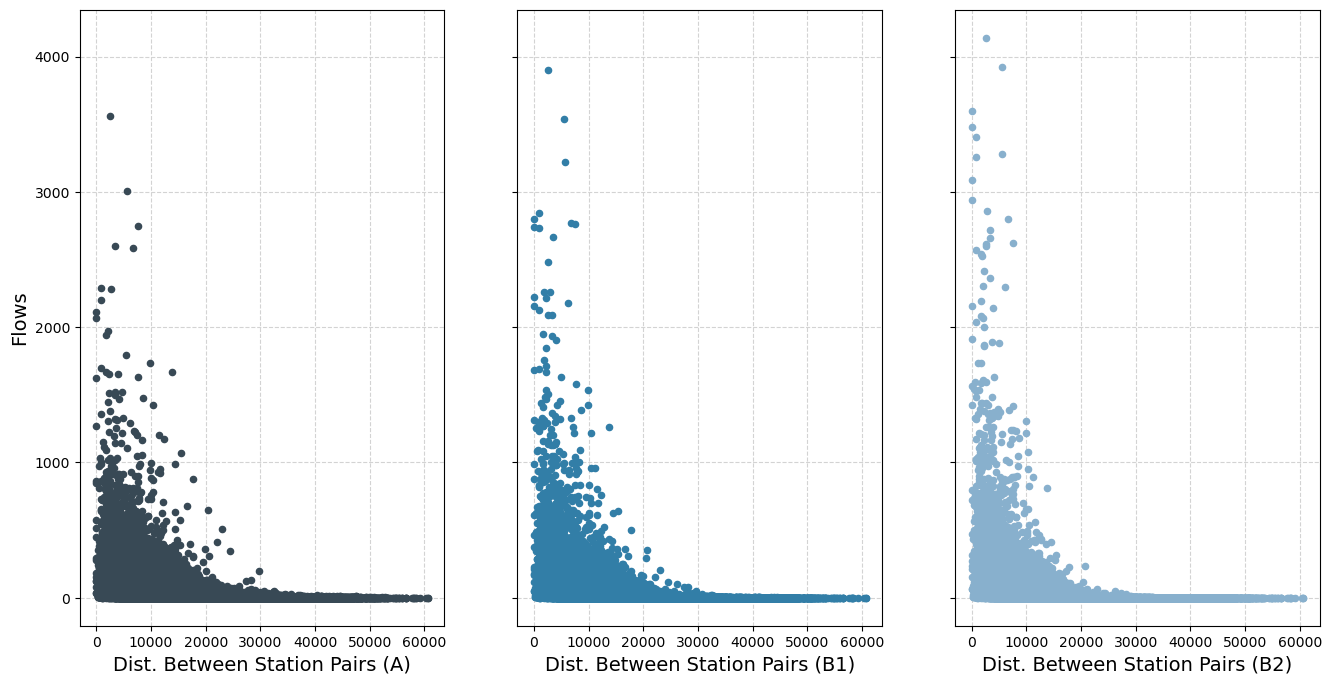

In [18]:
#Scatterplot/regression
#Basic vis
fig, axs = plt.subplots(1, 3, sharey=True, sharex=True)

plta = flows.plot(kind='scatter', x='distance', y='flows_scenario_a', ax=axs[0], figsize=(16, 8), color='#384955', zorder=2)
plta.set_xlabel('Dist. Between Station Pairs (A)', fontsize=14)
plta.set_ylabel('Flows' ,fontsize=14)
plta.grid(color='#d3d3d3', linestyle='--', zorder=1)

pltb1 = flows.plot(kind='scatter', x='distance', y='flows_scenario_b1', ax=axs[1], figsize=(16, 8), color='#327EA7', zorder=2)
pltb1.set_xlabel('Dist. Between Station Pairs (B1)', fontsize=14)
pltb1.set_ylabel('Flows' ,fontsize=14)
pltb1.grid(color='#d3d3d3', linestyle='--', zorder=1)

pltb2 = flows.plot(kind='scatter', x='distance', y='flows_scenario_b2', ax=axs[2], figsize=(16, 8), color='#88B0CD', zorder=2)
pltb2.set_xlabel('Dist. Between Station Pairs (B2)', fontsize=14)
pltb2.set_ylabel('Flows' ,fontsize=14)
pltb2.grid(color='#d3d3d3', linestyle='--', zorder=1)

/Users/gavinrolls/anaconda3/envs/urbsim/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


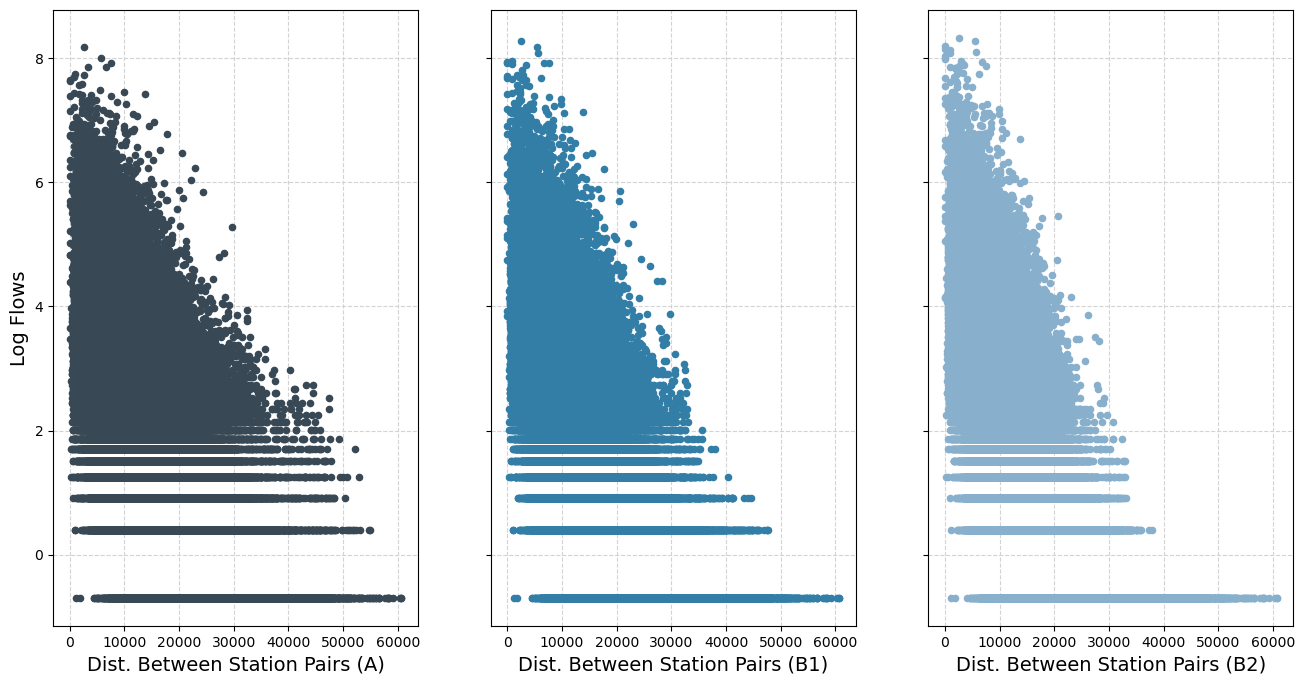

In [19]:
#Scatterplot/regression log versus distance

fig, axs = plt.subplots(1, 3, sharey=True, sharex=True)

flows['log_flows_scenario_a'] = np.log(flows['flows_scenario_a'] + .5)
flows['log_flows_scenario_b1'] = np.log(flows['flows_scenario_b1'] + .5)
flows['log_flows_scenario_b2'] = np.log(flows['flows_scenario_b2']+ .5)

flows['log_dist'] = np.log(flows['distance'])

plta = flows.plot(kind='scatter', x='distance', y='log_flows_scenario_a', ax=axs[0], figsize=(16, 8), color='#384955', zorder=2)
plta.set_xlabel('Dist. Between Station Pairs (A)', fontsize=14)
plta.set_ylabel('Log Flows' ,fontsize=14)
plta.grid(color='#d3d3d3', linestyle='--', zorder=1)

pltb1 = flows.plot(kind='scatter', x='distance', y='log_flows_scenario_b1', ax=axs[1], figsize=(16, 8), color='#327EA7', zorder=2)
pltb1.set_xlabel('Dist. Between Station Pairs (B1)', fontsize=14)
pltb1.set_ylabel('Log Flows' ,fontsize=14)
pltb1.grid(color='#d3d3d3', linestyle='--', zorder=1)

pltb2 = flows.plot(kind='scatter', x='distance', y='log_flows_scenario_b2', ax=axs[2], figsize=(16, 8), color='#88B0CD', zorder=2)
pltb2.set_xlabel('Dist. Between Station Pairs (B2)', fontsize=14)
pltb2.set_ylabel('Log Flows' ,fontsize=14)
pltb2.grid(color='#d3d3d3', linestyle='--', zorder=1)

In [20]:
#Linear Regression of each of the above figures
a_reg = smf.ols(formula='log_flows_scenario_a ~ distance', data = flows).fit()
b1_reg = smf.ols(formula='log_flows_scenario_b1 ~ distance', data = flows).fit()
b2_reg = smf.ols(formula='log_flows_scenario_b2 ~ distance', data = flows).fit()

print('Beta_1 for Scenario A: ' + str(a_reg.params[1]))
print('Beta_1 for Scenario B1: ' + str(b1_reg.params[1]))
print('Beta_1 for Scenario B2: ' + str(b2_reg.params[1]))

print(a_reg.summary())
print(b1_reg.summary())
print(b2_reg.summary())


Beta_1 for Scenario A: -0.00010649456855481164
Beta_1 for Scenario B1: -0.00012847561818171097
Beta_1 for Scenario B2: -0.00014107511373882167
                             OLS Regression Results                             
Dep. Variable:     log_flows_scenario_a   R-squared:                       0.371
Model:                              OLS   Adj. R-squared:                  0.371
Method:                   Least Squares   F-statistic:                 3.631e+04
Date:                  Fri, 08 Mar 2024   Prob (F-statistic):               0.00
Time:                          10:57:14   Log-Likelihood:            -1.0344e+05
No. Observations:                 61451   AIC:                         2.069e+05
Df Residuals:                     61449   BIC:                         2.069e+05
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t    

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_84129/587890093.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Beta_1 for Scenario A: ' + str(a_reg.params[1]))
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_84129/587890093.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Beta_1 for Scenario B1: ' + str(b1_reg.params[1]))
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_84129/587890093.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behav